**NOTES**

Using this notebook with CASIAv2.0 dataset requires a runtime with at least 128GB of system RAM and 32GB of disk. If you are running this in Google Colab, it might require a **paid** subscription. With a v2-8 TPU runtime, it took more than 24h time (or 42.24 compute units) to run the whole notebook. This may result in a direct cost around 4 to 5 EUR as of 4th January 2025, and runtime may be terminated without notice before completing.

Before execution, review carefully all paths. This notebook expects to have all npy files already generated. In order to generate them, please use the provided dedicated notebook.

As we did the work with tensorflow 2.15.0 we are forcing that version to ensure no compatibility issues appear. It might not be strictly necessary to stick to that version, though.

This notebook is structured in three sections. One that is common for both the binary classifier and for the localizer, which loads the required data into memory, and then one section for each model.



**COMMON FOR BINARY CLASSIFIER AND LOCALIZER**

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
CNN_AUTHENTIC_DIRECTORY = '/content/gdrive/MyDrive/TFM/datasets/CASIA2/Au'
CNN_TAMPERED_DIRECTORY = '/content/gdrive/MyDrive/TFM/datasets/CASIA2/Tp'
CNN_GROUND_TRUTH_DIRECTORY = '/content/gdrive/MyDrive/TFM/datasets/CASIA2/gt_all_grayscale'
AUGMENTED_MASK_DIRECTORY = CNN_GROUND_TRUTH_DIRECTORY + "/augment"

In [ ]:
def get_npy_directory(directory):
    return directory + '/npy'

def get_npy_file(directory, file):
    return get_npy_directory(directory) + '/' + file + '.npy'

def get_npy_authentic_file():
    return get_npy_directory(CNN_GROUND_TRUTH_DIRECTORY) + '/authentic.npy'

def file_exists(file):
  return os.path.exists(file)

In [ ]:
import random
import numpy as np
import os
import threading

lock = threading.Lock()

def iterate_directory(directory, is_tampered):
  list_of_files = os.listdir(directory)
  for file in list_of_files:
    if os.path.isfile(os.path.join(directory, file)) and (file.endswith(".jpg") or file.endswith(".bmp") or file.endswith(".tif")):
      if is_tampered and not cnn_groundtruth_exists(directory, file):
        print("skipping", file, "as it's tampered but no groundtruth file exists")
        continue
      if not file_exists(get_npy_file(directory, file)):
        print("skipping", get_npy_file(directory, file), "as it does not exist")
        continue
      with lock:
        add_to_training_set = np.random.choice([0, 1], p=[0.2, 0.8])                                            # 80% is initially reserved to training set, 20% remaining to test set
        if bool(add_to_training_set):
          append_to_training_set(directory, file, is_tampered)
        else:
          append_to_test_set(directory, file, is_tampered)
    else:
      print("skipping", file, "as it's not a JPG, BMP or TIF file")

def iterate_augmented_directory(directory, is_tampered):
  list_of_files = os.listdir(directory)
  for file in list_of_files:
    if is_tampered and not file_exists(CNN_GROUND_TRUTH_DIRECTORY + "/augment/npy/" + file):                # TODO Les màscares d'augment estan mal generades, els falta el _gt
      print("skipping", directory, "/", file, "as it's tampered but no groundtruth file exists")
      continue
    with lock:
      add_to_training_set = np.random.choice([0, 1], p=[0.2, 0.8])                                            # 80% is initially reserved to training set, 20% remaining to test set
      filename = directory + "/" + file
      if bool(add_to_training_set):
        CNN_TRAINING_SET.append(get_memmap_array_filename(filename))
        filename_to_load = (CNN_GROUND_TRUTH_DIRECTORY + "/augment/npy/" + file) if is_tampered else get_npy_authentic_file()
        CNN_TRAINING_LABEL_SET.append(get_memmap_array_filename(filename_to_load))
      else:
        CNN_TEST_SET.append(get_memmap_array_filename(filename))
        filename_to_load = (CNN_GROUND_TRUTH_DIRECTORY + "/augment/npy/" + file) if is_tampered else get_npy_authentic_file()
        CNN_TEST_LABEL_SET.append(get_memmap_array_filename(filename_to_load))

def append_to_training_set(directory, file, is_tampered):
  CNN_TRAINING_SET.append(get_memmap_array(directory, file))
  if is_tampered:
    CNN_TRAINING_LABEL_SET.append(get_memmap_array_filename(get_cnn_groundtruth_path(directory, file)))
  else:
    CNN_TRAINING_LABEL_SET.append(get_memmap_array_filename(get_npy_authentic_file()))

def append_to_test_set(directory, file, is_tampered):
  CNN_TEST_SET.append(get_memmap_array(directory, file))
  if is_tampered:
    CNN_TEST_LABEL_SET.append(get_memmap_array_filename(get_cnn_groundtruth_path(directory, file)))
  else:
    CNN_TEST_LABEL_SET.append(get_memmap_array_filename(get_npy_authentic_file()))

def get_cnn_groundtruth_path(directory, file):
  final_dir = get_augmented_image_directory(CNN_GROUND_TRUTH_DIRECTORY) if '/augment' in directory else CNN_GROUND_TRUTH_DIRECTORY
  return get_npy_directory(final_dir) + '/' + file[:-4] + '_gt.png.npy'

def cnn_groundtruth_exists(directory, file):
  #print("checking", get_cnn_groundtruth_path(directory, file))
  return os.path.exists(get_cnn_groundtruth_path(directory, file)) # e.g. Tp_S_NNN_S_N_sec00054_sec00055_11341_gt.png does not exist.

def file_exists(file):
  return os.path.exists(file)

def get_memmap_array(directory, file):
  filename = get_npy_file(directory, file)
  return get_memmap_array_filename(filename)

def get_memmap_array_filename(filename):
  return np.load(filename, mmap_mode='r')

def get_augmented_image_directory(directory):
  return directory + "/augment"

In [ ]:
CNN_TRAINING_SET = []
CNN_TRAINING_LABEL_SET = []
CNN_TEST_SET = []
CNN_TEST_LABEL_SET = []

# Populate sets
import concurrent.futures

# Define the directory processing tasks as separate functions
def process_augmented_tampered():
    iterate_augmented_directory(CNN_TAMPERED_DIRECTORY + "/augment/npy", True)

def process_augmented_authentic():
    iterate_augmented_directory(CNN_AUTHENTIC_DIRECTORY + "/augment/npy", False)

def process_tampered():
    iterate_directory(CNN_TAMPERED_DIRECTORY, True)

def process_authentic():
    iterate_directory(CNN_AUTHENTIC_DIRECTORY, False)

# Run each function in a separate thread
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_augmented_tampered),
        executor.submit(process_augmented_authentic),
        executor.submit(process_tampered),
        executor.submit(process_authentic)
    ]
    # Wait for all tasks to complete
    for future in concurrent.futures.as_completed(futures):
        future.result()  # This will raise an exception if any occurred

# At this point all sets are populated
print("train set size: ", len(CNN_TRAINING_SET))
print("train label set size: ", len(CNN_TRAINING_LABEL_SET))
print("test set size : ", len(CNN_TEST_SET))
print("test label set size : ", len(CNN_TEST_LABEL_SET))

skipping Tp_S_NNN_S_N_sec00054_sec00055_11341.jpg as it's tampered but no groundtruth file exists
skipping Tp_S_NNN_S_N_sec20007_sec20007_02154.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NNN_S_O_txt00039_txt00042_10831.jpg as it's tampered but no groundtruth file exists
skipping Tp_S_NRD_S_B_cha00089_ani00013_00409.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NRD_S_B_pla20089_nat20043_02353.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NRD_S_B_cha20044_nat20042_02432.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NRN_M_N_cha10114_nat10114_12181.jpg as it's tampered but no groundtruth file exists
skipping Tp_S_NRN_M_N_cha00010_art00010_10170.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NRN_M_N_cha00085_ani10104_10029.tif as it's tampered but no groundtruth file exists
skipping Tp_S_NRN_M_N_nat10164_nat00097_12097.jpg as it's tampered but no groundtruth file exists
skipping Tp_S_NRN_M_

**BINARY CLASSIFIER**

In [ ]:
# Prepare for training
y = []
for i in range(len(CNN_TRAINING_LABEL_SET)):
  if 255 in CNN_TRAINING_LABEL_SET[i]:
      y.append(1) # Tampering
  else:
      y.append(0) # Authentic

instances_count = len(CNN_TRAINING_SET)

x = np.array(CNN_TRAINING_SET)
y = np.array(y)

print("size of training set", len(x))
print("size of training label set", len(y))

size of training set 13129
size of training label set 13129


In [ ]:
from functools import partial
import tensorflow as tf

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")

shape = [256, 384, 8]

model = tf.keras.Sequential([
   DefaultConv2D(filters=32, kernel_size=5, strides=1, input_shape=shape),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.MaxPool2D(),
   DefaultConv2D(filters=64),
   tf.keras.layers.MaxPool2D(),
   DefaultConv2D(filters=96),
   tf.keras.layers.MaxPool2D(),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(units=96, activation="relu", kernel_initializer="he_normal"),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)

num_authentic = np.sum(y == 0)
num_tampered = np.sum(y == 1)
all_instances = num_authentic + num_tampered
weight_authentic = all_instances / (2*num_authentic)
weight_tampered = all_instances / (2*num_tampered)

class_weights = {
    0: weight_authentic,
    1: weight_tampered
}

history = model.fit(x, y, epochs=100, validation_split=0.2, callbacks=[early_stopping], shuffle=True, class_weight=class_weights)

Epoch 1/100
329/329 [==============================] - 588s 2s/step - loss: 0.7075 - accuracy: 0.4855 - val_loss: 0.7846 - val_accuracy: 0.1196
Epoch 2/100
329/329 [==============================] - 590s 2s/step - loss: 0.6943 - accuracy: 0.4881 - val_loss: 0.7979 - val_accuracy: 0.1196
Epoch 3/100
329/329 [==============================] - 582s 2s/step - loss: 0.6867 - accuracy: 0.5241 - val_loss: 0.7317 - val_accuracy: 0.6169
Epoch 4/100
329/329 [==============================] - 585s 2s/step - loss: 0.6771 - accuracy: 0.5641 - val_loss: 0.6930 - val_accuracy: 0.6405
Epoch 5/100
329/329 [==============================] - 588s 2s/step - loss: 0.6665 - accuracy: 0.5857 - val_loss: 0.7467 - val_accuracy: 0.4741
Epoch 6/100
329/329 [==============================] - 587s 2s/step - loss: 0.6582 - accuracy: 0.6063 - val_loss: 0.8157 - val_accuracy: 0.3549
Epoch 7/100
329/329 [==============================] - 581s 2s/step - loss: 0.6467 - accuracy: 0.6193 - val_loss: 0.6549 - val_accuracy:

In [ ]:
model.save("/content/gdrive/MyDrive/TFM/FINAL____binary_classifier_model_for_tampering_detection_based_on_luminance_gradient.keras")

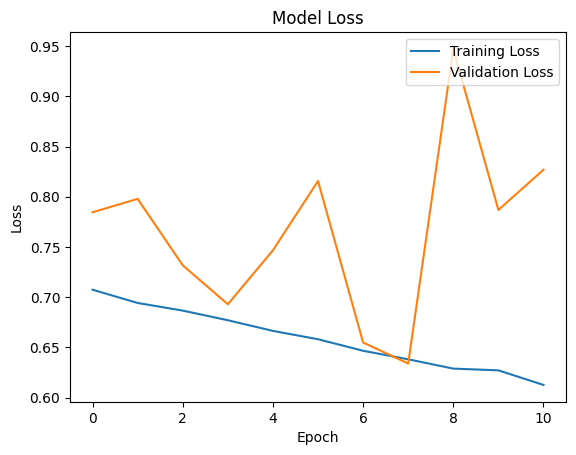

In [ ]:
# Plot training and validation losses so model convergence and overfitting can be visualized

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
instances = np.array(CNN_TEST_SET)
preds = model.predict(instances)

103/103 [==============================] - 51s 498ms/step


In [ ]:
y_test = []
for i in range(len(CNN_TEST_LABEL_SET)):
    if 255 in CNN_TEST_LABEL_SET[i]:
        y_test.append(1) # Tampering
    else:
        y_test.append(0) # Authentic

y_test = np.array(y_test)

print("train set size: ", len(x))
print("test set size : ", len(CNN_TEST_SET))

train set size:  13129
test set size :  3290


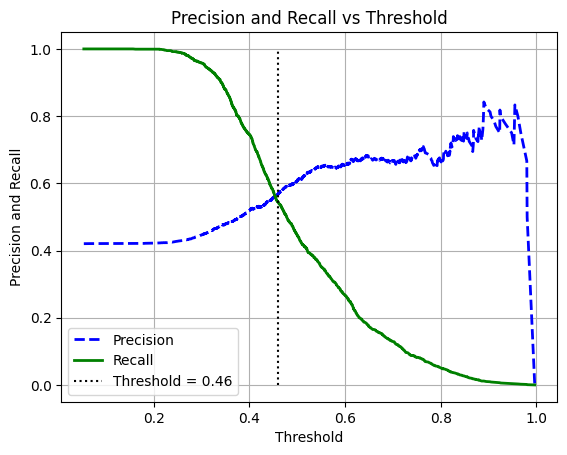

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, preds)

# Plot the Precision-Recall Curve against thresholds
threshold = 0.46
label = "Threshold = " + str(threshold)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label=label)

# Add axis titles
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")

# Add a legend
plt.legend(loc="best")

# Show the plot
plt.title("Precision and Recall vs Threshold")
plt.grid()
plt.show()

In [ ]:
# Anything at 46% probability or greater of being a 1 will be considered a 1 (tampered)
binary_classes = (preds >= threshold).astype(int)
binary_classes = binary_classes.flatten()

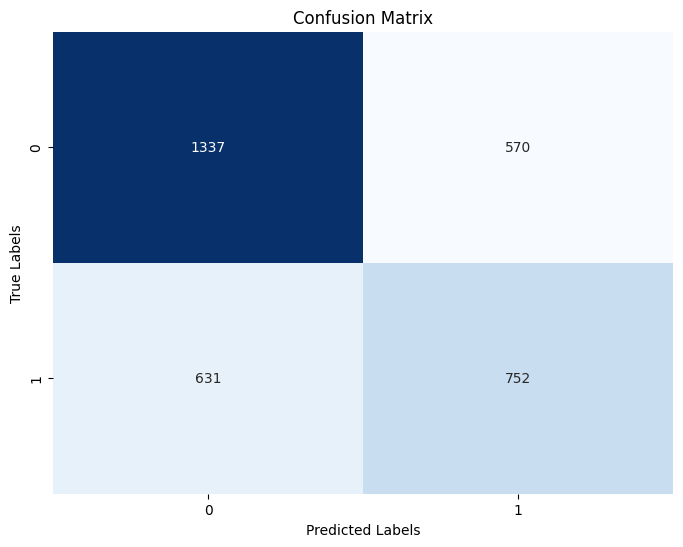

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, binary_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision     : ", round(precision_score(y_test, binary_classes, pos_label=1)*100,2), "%")
print("recall        : ", round(recall_score(y_test, binary_classes, pos_label=1)*100,2), "%")
print("f1 score      : ", round(f1_score(y_test, binary_classes, pos_label=1),2))

precision     :  56.88 %
recall        :  54.37 %
f1 score      :  0.56


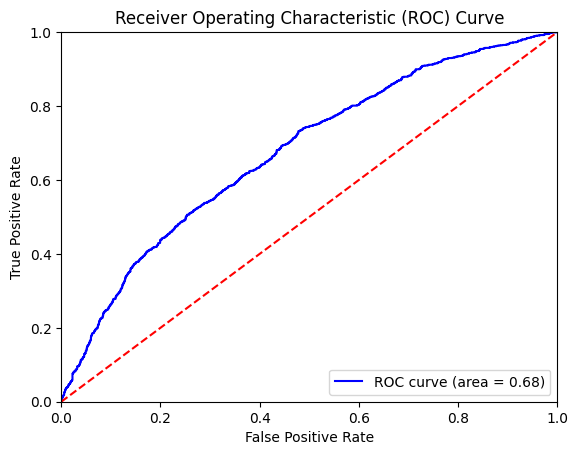

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, preds.ravel())

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**LOCALIZER**

In [ ]:
import tensorflow as tf
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")

shape = (256, 384, 8)

localizer_model = tf.keras.Sequential([
    # Downsampling path
    DefaultConv2D(filters=32, kernel_size=5, strides=1, input_shape=shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),  # Downsample by 2x

    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),  # Downsample by another 2x

    DefaultConv2D(filters=256),  # Extract deeper features (was 64)
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),  # Downsample by another 2x

    # Upsampling path
    tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same", activation="relu"),  # Upsample by 2x
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),  # Upsample by 2x
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),  # Upsample by 2x
    tf.keras.layers.BatchNormalization(),

    # Output layer
    tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation="sigmoid")  # Single-channel output
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

localizer_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
# Prepare for training
x = np.array(CNN_TRAINING_SET)
y = np.array(CNN_TRAINING_LABEL_SET)
y = np.expand_dims(y, axis=-1)
y = y // 255

print("size of training set", len(x))
print("size of training label set", len(y))

size of training set 13129
size of training label set 13129


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001)

# Get unique values and their counts
unique, counts = np.unique(y, return_counts=True)

# Assign the counts to num_authentic and num_tampered based on the unique values
num_authentic = counts[unique == 0][0] if 0 in unique else 0
num_tampered = counts[unique == 1][0] if 1 in unique else 0

all_instances = num_authentic + num_tampered

weight_authentic = all_instances / (2*num_authentic)
weight_tampered = all_instances / (2*num_tampered)

class_weights = {
    0: weight_authentic,
    1: weight_tampered
}

history_localizer = localizer_model.fit(x, y, epochs=100, validation_split=0.2, callbacks=[early_stopping], shuffle=True, class_weight=class_weights)

Epoch 1/100
329/329 [==============================] - 1822s 6s/step - loss: 0.7223 - accuracy: 0.1173 - val_loss: 0.7052 - val_accuracy: 0.2575
Epoch 2/100
329/329 [==============================] - 1845s 6s/step - loss: 0.7215 - accuracy: 0.0781 - val_loss: 0.7387 - val_accuracy: 0.0478
Epoch 3/100
329/329 [==============================] - 1829s 6s/step - loss: 0.7191 - accuracy: 0.0988 - val_loss: 0.7232 - val_accuracy: 0.0240
Epoch 4/100
329/329 [==============================] - 1841s 6s/step - loss: 0.7169 - accuracy: 0.2570 - val_loss: 0.7162 - val_accuracy: 0.3561
Epoch 5/100
329/329 [==============================] - 1867s 6s/step - loss: 0.7128 - accuracy: 0.4115 - val_loss: 1.0780 - val_accuracy: 0.1346
Epoch 6/100
329/329 [==============================] - 1857s 6s/step - loss: 0.7094 - accuracy: 0.2808 - val_loss: 0.7746 - val_accuracy: 0.1442
Epoch 7/100
329/329 [==============================] - 1822s 6s/step - loss: 0.7037 - accuracy: 0.4475 - val_loss: 0.6715 - val_ac

In [ ]:
localizer_model.save("/content/gdrive/MyDrive/TFM/FINAL____localizer_model_for_tampering_detection_based_on_luminance.keras")

In [ ]:
# Plot training and validation losses so model convergence and overfitting can be visualized

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_localizer.history['loss'], label='Training Loss')
plt.plot(history_localizer.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
instances = np.array(CNN_TEST_SET)
preds = localizer_model.predict(instances)

In [ ]:
y_test = np.array(CNN_TEST_LABEL_SET)
y_test = np.expand_dims(y_test, axis=-1)
y_test = y_test // 255

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), preds.ravel())

# Plot the Precision-Recall Curve against thresholds
threshold = 0.25
label = "Threshold = " + str(threshold)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label=label)

# Add axis titles
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")

# Add a legend
plt.legend(loc="best")

# Show the plot
plt.title("Precision and Recall vs Threshold")
plt.grid()
plt.show()

In [ ]:
binary_classes = (preds >= threshold).astype(int)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 random indices
random_indices = np.random.choice(len(binary_classes), 10, replace=False)

# Set up a plot with 10 rows and 2 columns
fig, axes = plt.subplots(10, 2, figsize=(10, 30))  # Adjust figure size as needed

for i, idx in enumerate(random_indices):
    predicted_image = binary_classes[idx].squeeze()
    truth_image = y_test[idx].squeeze()

    # Display predicted image
    axes[i, 0].imshow(predicted_image, cmap='gray')
    axes[i, 0].set_title(f"Predicted (Index {idx})")
    axes[i, 0].axis('off')

    # Display truth image
    axes[i, 1].imshow(truth_image, cmap='gray')
    axes[i, 1].set_title(f"Ground Truth (Index {idx})")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
binary_classes = binary_classes.flatten()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test.ravel(), binary_classes.ravel())

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision     : ", round(precision_score(y_test.ravel(), binary_classes.ravel(), pos_label=1)*100,2), "%")
print("recall        : ", round(recall_score(y_test.ravel(), binary_classes.ravel(), pos_label=1)*100,2), "%")
print("f1 score      : ", round(f1_score(y_test.ravel(), binary_classes.ravel(), pos_label=1),2))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test.ravel(), preds.ravel())

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()